# Outreach about Community Composting at Select MTA Stations 

- The purpose of this project was to identify MTA stations at which to conduct outreach to promote the practice of composting. 
- My criteria for selecting stations were:
  - moderate traffic flow
  - close proximity to food scrap drop-off locations 
- I used three datasets for this project:
  - 1. MTA turnstile data
  - 2. MTA stations' location data (from here: http://web.mta.info/developers/developer-data-terms.html#data)
  - 3. Food scrap drop-off sites' location data (from here: https://data.cityofnewyork.us/Environment/Food-Scrap-Drop-Off-Locations-in-NYC/if26-z6xq)
- Originally, I planned to select a station in each borough but once I filtered down to stations with around the median amount of average daily entries/exits (between 2500-3000) in the 3-month time period I chose, there were no Staten Island stations.

In [1]:
pwd

'/Users/chloebergsma-safar/Desktop/Bootcamp Work'

In [201]:
import os 
os.chdir ('/Users/chloebergsma-safar/Desktop/Bootcamp_Data')

In [202]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlalchemy
import geopandas as gpd
from shapely.geometry import Point, Polygon
from math import radians, cos, sin, asin, sqrt
#import haversine as hs
#from haversine import Unit

# Read in data

## Read in mta turnstiles data

In [4]:
mta_turnstile_db = "mta_data.db"
mta_data = "mta_data"

engine = sqlalchemy.create_engine("sqlite:///%s" % mta_turnstile_db, execution_options={"sqlite_raw_colnames": True})
mta_turnstiles = pd.read_sql_table(mta_data, engine)

## Read in mta stations location data

In [5]:
mta_stations = pd.read_csv('mta stations locations.csv')

## Read in food scrap drop-off sites location data

In [203]:
compost_drop_off = pd.read_csv('Food_Scrap_Drop-Off_Locations_in_NYC.csv')

# Clean mta turnstiles data

In [7]:
mta_turnstiles.shape

(2930792, 11)

In [8]:
mta_turnstiles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930792 entries, 0 to 2930791
Data columns (total 11 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   C/A       object
 1   UNIT      object
 2   SCP       object
 3   STATION   object
 4   LINENAME  object
 5   DIVISION  object
 6   DATE      object
 7   TIME      object
 8   DESC      object
 9   ENTRIES   int64 
 10  EXITS     int64 
dtypes: int64(2), object(9)
memory usage: 246.0+ MB


In [9]:
# see if there are any NaN values in mta_turnstiles
mta_turnstiles.isna().sum()

C/A         0
UNIT        0
SCP         0
STATION     0
LINENAME    0
DIVISION    0
DATE        0
TIME        0
DESC        0
ENTRIES     0
EXITS       0
dtype: int64

In [10]:
# make column names lowercase
mta_turnstiles.columns = [column.lower() for column in mta_turnstiles.columns]

In [11]:
# combine the date and time fields into a single datetime column 
mta_turnstiles['date_time'] = pd.to_datetime(mta_turnstiles.date + " " + mta_turnstiles.time, 
                                            format="%m/%d/%Y %H:%M:%S")

In [12]:
# remove rows and drop any duplicate entries
mta_turnstiles.sort_values(['c/a', 'unit', 'scp', 'station', 'date_time'], 
                          inplace=True, ascending=False)
mta_turnstiles.drop_duplicates(subset=['c/a', 'unit', 'scp', 'station', 'date_time'], inplace=True)

In [13]:
# drop columns not needed for analysis
mta_turnstiles = mta_turnstiles.drop(['linename', 'division', 'desc'], axis=1, errors="ignore")

In [14]:
mta_turnstiles.shape

(2930742, 9)

## Analyze entries data

- Since one of my criterion for selecting stations was traffic flow, I decided to use the average daily entries/exits of each station as a proxy for this metric.
- Thus, I first needed to clean entries data at the turnstile level and then at the station level before doing the same with exits and then combining them.

In [15]:
# create df of daily turnstiles cumulative entries
mta_turnstiles_cum_entries_daily = (mta_turnstiles
                        .groupby(['c/a', 'unit', 'scp', 'station', 'date'],as_index=False)
                        .entries.first())

In [16]:
mta_turnstiles_cum_entries_daily.head()

,c/a,unit,scp,station,date,entries
0,A002,R051,02-00-00,59 ST,04/24/2021,7561578
1,A002,R051,02-00-00,59 ST,04/25/2021,7561843
2,A002,R051,02-00-00,59 ST,04/26/2021,7562300
3,A002,R051,02-00-00,59 ST,04/27/2021,7562873
4,A002,R051,02-00-00,59 ST,04/28/2021,7563448


In [17]:
# create prev_date and prev_entries columns to calculate new daily entries
mta_turnstiles_cum_entries_daily[['prev_date', 'prev_entries']] = (mta_turnstiles_cum_entries_daily
                        .groupby(['c/a', 'unit', 'scp', 'station'])['date', 'entries']
                        .apply(lambda x: x.shift(1)))

<ipython-input-17-fee1c21a5acf>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mta_turnstiles_cum_entries_daily[['prev_date', 'prev_entries']] = (mta_turnstiles_cum_entries_daily


In [18]:
mta_turnstiles_cum_entries_daily.head()

,c/a,unit,scp,station,date,entries,prev_date,prev_entries
0,A002,R051,02-00-00,59 ST,04/24/2021,7561578,NaN,NaN
1,A002,R051,02-00-00,59 ST,04/25/2021,7561843,04/24/2021,7561578.0
2,A002,R051,02-00-00,59 ST,04/26/2021,7562300,04/25/2021,7561843.0
3,A002,R051,02-00-00,59 ST,04/27/2021,7562873,04/26/2021,7562300.0
4,A002,R051,02-00-00,59 ST,04/28/2021,7563448,04/27/2021,7562873.0


In [19]:
# drop the row for the earliest date in the df
mta_turnstiles_cum_entries_daily.dropna(subset=['prev_date'], axis=0, inplace=True)

In [20]:
mta_turnstiles_cum_entries_daily.head()

,c/a,unit,scp,station,date,entries,prev_date,prev_entries
1,A002,R051,02-00-00,59 ST,04/25/2021,7561843,04/24/2021,7561578.0
2,A002,R051,02-00-00,59 ST,04/26/2021,7562300,04/25/2021,7561843.0
3,A002,R051,02-00-00,59 ST,04/27/2021,7562873,04/26/2021,7562300.0
4,A002,R051,02-00-00,59 ST,04/28/2021,7563448,04/27/2021,7562873.0
5,A002,R051,02-00-00,59 ST,04/29/2021,7563968,04/28/2021,7563448.0


In [21]:
# check min and max of entries and prev_entries
print(mta_turnstiles_cum_entries_daily.entries.min())
print(mta_turnstiles_cum_entries_daily.entries.max())
print(mta_turnstiles_cum_entries_daily.prev_entries.min())
print(mta_turnstiles_cum_entries_daily.prev_entries.max())

0
2147429408
0.0
2147429588.0


- The above cell indicates that the day's maximum cumulative entries value (2,147,429,408) is less than the previous day's maximum cumulative entries value (2,147,429,588), which seems odd. 

- This is something worth investigating.

In [22]:
# check how many rows have the current day's entries as less than the previous day's entries amount
len(mta_turnstiles_cum_entries_daily[mta_turnstiles_cum_entries_daily['entries'] < mta_turnstiles_cum_entries_daily['prev_entries']])

4560

- Create a new column of entries amounts that will recode the rows where the current day's entries are less than the previous day's entries.

In [23]:
# create a function to recode rows where entries is less than prev_entries
def get_daily_entries_counts(row, max_counter):
    counter = row['entries'] - row['prev_entries']
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        print(row['entries'], row['prev_entries'])
        counter = min(row['entries'], row['prev_entries'])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

# If counter is > 10,000, then the counter might have been reset.  
# Just set it to zero as different counters have different cycle limits
mta_turnstiles_cum_entries_daily['daily_entries'] = mta_turnstiles_cum_entries_daily.apply(get_daily_entries_counts, axis=1, max_counter=10000)

59 154688.0
3082 1390173.0
29 479839.0
427 67581.0
18 4340953.0
44 13117.0
187 30721.0
14 1028362.0
93 765803.0
5 150038.0
327680 756269765.0
385 327866.0
25 262152.0
353 8049630.0
0 5309746.0
458752 24.0
262309 279345.0
101 2651127.0
393219 459438.0
166 20146.0
458754 262214.0
8 458758.0
457 59478.0
65 106396.0
458754 262144.0
393216 458752.0
1946307751 1946273868.0
42 72848.0
901 659349.0
327680 4.0
1 327690.0
24 2627860.0
327680 262144.0
166 89658.0
241 59609.0
153 1604971.0
5946 4298704.0
0 117440512.0
83 366981.0
135 8882903.0
340 157816.0
517037 484260.0
113 4454729.0
158 7643335.0
331 500527.0
327975 7577027.0
217 4780275.0
85 490316.0
4 1534984197.0
67109632 14.0
327682 67109640.0
67109632 1.0
15 67109632.0
87 755027.0
12517611 82.0
46 5405351.0
687970551 19471253.0
458753 393246.0
1076 7489966.0
16777220 1037157.0
463 6101664.0
162 1110928.0
327 2524852.0
34 692662.0
374 152140.0
262150 2393328.0
458814 271001.0
322 48953.0
327682 786526.0
327680 0.0
67436550 375578.0
143 4070

In [24]:
mta_turnstiles_cum_entries_daily.head()

,c/a,unit,scp,station,date,entries,prev_date,prev_entries,daily_entries
1,A002,R051,02-00-00,59 ST,04/25/2021,7561843,04/24/2021,7561578.0,265.0
2,A002,R051,02-00-00,59 ST,04/26/2021,7562300,04/25/2021,7561843.0,457.0
3,A002,R051,02-00-00,59 ST,04/27/2021,7562873,04/26/2021,7562300.0,573.0
4,A002,R051,02-00-00,59 ST,04/28/2021,7563448,04/27/2021,7562873.0,575.0
5,A002,R051,02-00-00,59 ST,04/29/2021,7563968,04/28/2021,7563448.0,520.0


- Now that we've cleaned entries data at the turnstile level, let's look at the data at the station level.

In [25]:
# create new df of daily entries by station
station_entries_daily = mta_turnstiles_cum_entries_daily.groupby(['station', 'date'])[['daily_entries']].sum().reset_index()
station_entries_daily.head()

,station,date,daily_entries
0,1 AV,04/25/2021,4578.0
1,1 AV,04/26/2021,6686.0
2,1 AV,04/27/2021,6895.0
3,1 AV,04/28/2021,7118.0
4,1 AV,04/29/2021,7144.0


In [26]:
# calculate average daily entries by station and sort to see stations with lowest average daily entries
station_entries_daily_avg = station_entries_daily.groupby(['station'], as_index=False).daily_entries.mean().round(0)
station_entries_daily_avg.sort_values('daily_entries', inplace=True)
station_entries_daily_avg.reset_index(inplace=True)
station_entries_daily_avg.head()

,index,station,daily_entries
0,309,ORCHARD BEACH,7.0
1,162,BROAD CHANNEL,112.0
2,141,BEACH 105 ST,115.0
3,148,BEACH 98 ST,170.0
4,354,TOMPKINSVILLE,280.0


In [27]:
# look at stations with highest average daily entries
station_entries_daily_avg.tail()

,index,station,daily_entries
374,68,42 ST-PORT AUTH,27807.0
375,110,86 ST,28817.0
376,233,GRD CNTRL-42 ST,29189.0
377,59,34 ST-HERALD SQ,32487.0
378,61,34 ST-PENN STA,41056.0


In [28]:
station_entries_daily_avg.daily_entries.describe()

count      379.000000
mean      4687.965699
std       5445.618245
min          7.000000
25%       1617.000000
50%       2921.000000
75%       5237.500000
max      41056.000000
Name: daily_entries, dtype: float64

(array([246.,  79.,  31.,   7.,   2.,   6.,   4.,   3.,   0.,   1.]),
 array([7.00000e+00, 4.11190e+03, 8.21680e+03, 1.23217e+04, 1.64266e+04,
        2.05315e+04, 2.46364e+04, 2.87413e+04, 3.28462e+04, 3.69511e+04,
        4.10560e+04]),
 <a list of 10 Patch objects>)

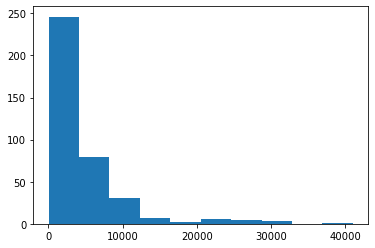

In [29]:
# look at a histogram of average daily entries by station
plt.hist(station_entries_daily_avg.daily_entries)

- The above histogram shows the distribute of average daily entries by station. We can see that it's skewed to right.
- Most stations' average daily entries amount is less than 5000.

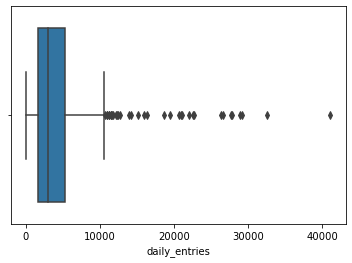

In [30]:
# find what average daily entries amounts are considered outliers
sns.boxplot(x='daily_entries',data=station_entries_daily_avg)

- The above plot shows that stations with average daily entries over ~10,000 are considered outliers.

## Analyze exits data

- Now, I will do the same cleaning and analysis of entries on exits.

In [31]:
# create df of daily turnstiles cumulative exits
mta_turnstiles_cum_exits_daily = (mta_turnstiles
                        .groupby(['c/a', 'unit', 'scp', 'station', 'date'],as_index=False)
                        .exits.first())

In [32]:
mta_turnstiles_cum_exits_daily.head()

,c/a,unit,scp,station,date,exits
0,A002,R051,02-00-00,59 ST,04/24/2021,2583031
1,A002,R051,02-00-00,59 ST,04/25/2021,2583132
2,A002,R051,02-00-00,59 ST,04/26/2021,2583332
3,A002,R051,02-00-00,59 ST,04/27/2021,2583535
4,A002,R051,02-00-00,59 ST,04/28/2021,2583805


In [33]:
# calculate daily new exits column 
mta_turnstiles_cum_exits_daily[['prev_date', 'prev_exits']] = (mta_turnstiles_cum_exits_daily
                        .groupby(['c/a', 'unit', 'scp', 'station'])['date', 'exits']
                        .apply(lambda x: x.shift(1)))

<ipython-input-33-6d7882bbe53b>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mta_turnstiles_cum_exits_daily[['prev_date', 'prev_exits']] = (mta_turnstiles_cum_exits_daily


In [34]:
mta_turnstiles_cum_exits_daily.head()

,c/a,unit,scp,station,date,exits,prev_date,prev_exits
0,A002,R051,02-00-00,59 ST,04/24/2021,2583031,NaN,NaN
1,A002,R051,02-00-00,59 ST,04/25/2021,2583132,04/24/2021,2583031.0
2,A002,R051,02-00-00,59 ST,04/26/2021,2583332,04/25/2021,2583132.0
3,A002,R051,02-00-00,59 ST,04/27/2021,2583535,04/26/2021,2583332.0
4,A002,R051,02-00-00,59 ST,04/28/2021,2583805,04/27/2021,2583535.0


In [35]:
# drop row with NaN values in prev_date and prev_exits
mta_turnstiles_cum_exits_daily.dropna(subset=['prev_date'], axis=0, inplace=True)

In [36]:
# check how many rows have count exits less than prev_exits
len(mta_turnstiles_cum_exits_daily[mta_turnstiles_cum_exits_daily['exits'] < mta_turnstiles_cum_exits_daily['prev_exits']])

3200

In [37]:
# create a function to recode rows where exits is less than prev_exits
def get_daily_exits_counts(row, max_counter):
    counter = row['exits'] - row['prev_exits']
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        print(row['exits'], row['prev_exits'])
        counter = min(row['exits'], row['prev_exits'])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

# If counter is > 10,000, then the counter might have been reset.  
# Just set it to zero as different counters have different cycle limits
mta_turnstiles_cum_exits_daily['daily_exits'] = mta_turnstiles_cum_exits_daily.apply(get_daily_exits_counts, axis=1, max_counter=10000)

56 167440.0
517 995815.0
62 154037.0
232 34338.0
6 808408.0
56 10571.0
4628405 4609822.0
4640239 4628405.0
106 25502.0
15 538441.0
218 1653807.0
104 436767770.0
165 2357391.0
0 3196184.0
137 2192493.0
306 13866.0
602 1025567.0
259 160229.0
0 67865.0
66 2944229.0
323 161084.0
163 43656.0
94 561746.0
3870 494138.0
306 1150397.0
14 751570.0
66 22377.0
145 2774389.0
54 6592830.0
220 477096.0
106 2004675.0
133 8070982.0
168 319261.0
236 563806220.0
148 32800.0
14090596 149.0
50 1851686.0
1174467683 4611970.0
239 1671513.0
13 415998.0
379 3350287.0
364 1150163.0
1073 2809308.0
278 6525554.0
1269 426447.0
14 3077761.0
116 22636.0
3 19574.0
189 5011886.0
0 11489500.0
1046 547475.0
10 224122.0
327681 22589.0
193 625286.0
0 654311429.0
61750 422855.0
43 80388.0
1171 370123.0
1114 15135.0
1002 71711.0
7 16336.0
487 399602.0
133 110581.0
1373 983880.0
149224 68650.0
68843 149224.0
71 12271.0
202 32249.0
268 24700.0
1002 11652.0
57882 47718.0
0 204513.0
108 31334.0
9 23129.0
13 30164.0
211 734409.0

In [38]:
mta_turnstiles_cum_exits_daily.head()

,c/a,unit,scp,station,date,exits,prev_date,prev_exits,daily_exits
1,A002,R051,02-00-00,59 ST,04/25/2021,2583132,04/24/2021,2583031.0,101.0
2,A002,R051,02-00-00,59 ST,04/26/2021,2583332,04/25/2021,2583132.0,200.0
3,A002,R051,02-00-00,59 ST,04/27/2021,2583535,04/26/2021,2583332.0,203.0
4,A002,R051,02-00-00,59 ST,04/28/2021,2583805,04/27/2021,2583535.0,270.0
5,A002,R051,02-00-00,59 ST,04/29/2021,2584076,04/28/2021,2583805.0,271.0


In [39]:
# create new df of daily exits by station
station_exits_daily = mta_turnstiles_cum_exits_daily.groupby(['station', 'date'])[['daily_exits']].sum().reset_index()
station_exits_daily.head()

,station,date,daily_exits
0,1 AV,04/25/2021,8539.0
1,1 AV,04/26/2021,10734.0
2,1 AV,04/27/2021,11460.0
3,1 AV,04/28/2021,11741.0
4,1 AV,04/29/2021,11801.0


In [40]:
# calculate average daily exits by station and sort to see stations with lowest average daily exits
station_exits_daily_avg = station_exits_daily.groupby(['station'], as_index=False).daily_exits.mean().round(0)
station_exits_daily_avg.sort_values('daily_exits', inplace=True)
station_exits_daily_avg.reset_index(inplace=True)
station_exits_daily_avg.head()

,index,station,daily_exits
0,344,ST. GEORGE,0.0
1,354,TOMPKINSVILLE,0.0
2,309,ORCHARD BEACH,4.0
3,329,RIT-MANHATTAN,46.0
4,330,RIT-ROOSEVELT,53.0


In [41]:
station_exits_daily_avg.tail()

,index,station,daily_exits
374,14,14 ST-UNION SQ,36827.0
375,110,86 ST,38416.0
376,233,GRD CNTRL-42 ST,40888.0
377,59,34 ST-HERALD SQ,42417.0
378,61,34 ST-PENN STA,55227.0


In [42]:
station_exits_daily_avg.daily_exits.describe()

count      379.000000
mean      5287.506596
std       6989.540664
min          0.000000
25%       1516.000000
50%       3079.000000
75%       5830.000000
max      55227.000000
Name: daily_exits, dtype: float64

(array([277.,  60.,  20.,   7.,   5.,   3.,   4.,   2.,   0.,   1.]),
 array([    0. ,  5522.7, 11045.4, 16568.1, 22090.8, 27613.5, 33136.2,
        38658.9, 44181.6, 49704.3, 55227. ]),
 <a list of 10 Patch objects>)

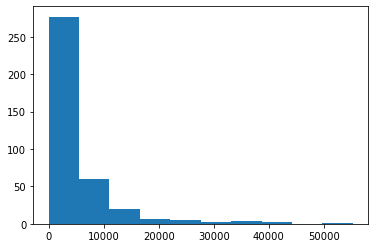

In [43]:
# look at a histogram of average daily exits by station
plt.hist(station_exits_daily_avg.daily_exits)

- Similar to the distribution of average daily entries, the distribution of average daily exits per station is also skewed to the right.
- Additionally, most stations' average daily exits is between 0 and 5000.

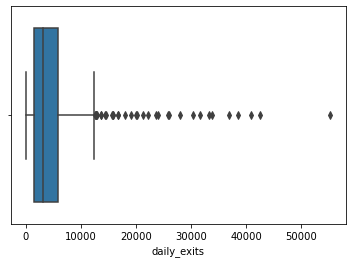

In [44]:
# find what average daily exits amounts are considered outliers
sns.boxplot(x='daily_exits',data=station_exits_daily_avg)

- The above plot shows that stations with average daily exits over ~12,500 are considered outliers.

# Merge dfs station_entries_daily_avg and station_exits_daily_avg
- To calculate the weighted mean of average daily entries and exits of the MTA stations - which is my proxy for traffic flow (one of my criteria for station selection for outreach about composting) - I need to combine the above dataframes I made that separately include average daily entries and exits by station.

In [45]:
# get shape of each df
print(station_entries_daily_avg.shape)
print(station_exits_daily_avg.shape)

(379, 3)
(379, 3)


In [46]:
# find columns in common
station_entries_daily_avg.columns.intersection(station_exits_daily_avg.columns)

Index(['index', 'station'], dtype='object')

In [47]:
# drop index column from both dfs
station_entries_daily_avg = station_entries_daily_avg.drop('index', axis=1)
station_exits_daily_avg = station_exits_daily_avg.drop('index', axis=1)

In [48]:
# merge on station, the column in common
station_daily_avg = pd.merge(station_entries_daily_avg, station_exits_daily_avg, on='station')

In [49]:
station_daily_avg.shape

(379, 3)

In [50]:
station_daily_avg.head()

,station,daily_entries,daily_exits
0,ORCHARD BEACH,7.0,4.0
1,BROAD CHANNEL,112.0,71.0
2,BEACH 105 ST,115.0,195.0
3,BEACH 98 ST,170.0,265.0
4,TOMPKINSVILLE,280.0,0.0


# Calculate weighted mean of avg daily entries and exits per station
- To do this, I need to know how many days worth of data each station had to calculate the average number of entries and average number of exits per station.
- Since the number of days per station will be the same for entries and exits, I will only use the df station_entries_daily, which was used to calculate the average number of entries and contains the date column.

In [51]:
# create a series that counts the number of days' worth of entries/exits each station has
count_dates = (station_entries_daily.groupby('station').date.count())

In [52]:
# convert series to df
count_dates_df = count_dates.to_frame()
count_dates_df.head()

,date
station,
1 AV,97
103 ST,97
103 ST-CORONA,97
104 ST,97
110 ST,97


In [53]:
# make the station name a column in the df
count_dates_df.reset_index(inplace=True)

In [54]:
# change the name of the date column
count_dates_df.rename(columns={'date':'count_dates'}, inplace=True)

In [55]:
count_dates_df.head()

,station,count_dates
0,1 AV,97
1,103 ST,97
2,103 ST-CORONA,97
3,104 ST,97
4,110 ST,97


In [56]:
count_dates_df.count_dates.unique()

array([97, 95, 94, 93, 54, 96])

# Merge dfs station_daily_avg with count_dates_df 
- This needs to be done to get the daily average number of entries per station, daily average number of exits per station, and the number of days' worth of data per station in the same df to calculate the weighted average of both entries and exits per station.

In [57]:
station_daily_avg.shape

(379, 3)

In [58]:
count_dates_df.shape

(379, 2)

In [59]:
station_daily_avg_counts = station_daily_avg.merge(count_dates_df,on='station')

In [60]:
station_daily_avg_counts.shape

(379, 4)

In [61]:
station_daily_avg_counts.head()

,station,daily_entries,daily_exits,count_dates
0,ORCHARD BEACH,7.0,4.0,54
1,BROAD CHANNEL,112.0,71.0,97
2,BEACH 105 ST,115.0,195.0,97
3,BEACH 98 ST,170.0,265.0,97
4,TOMPKINSVILLE,280.0,0.0,97


In [62]:
# create a function that calculates the weighted average number of daily entries/exits per station and then
  # apply the function to the df to create a new column with this data
def weighted_mean(row):
        return (row['daily_entries'] * row['count_dates'] + row['daily_exits'] * row['count_dates']) / (row['count_dates'] + row['count_dates'])
    
station_daily_avg_counts['avg_daily_entries_exits'] = station_daily_avg_counts.apply(weighted_mean, axis=1)

In [63]:
station_daily_avg_counts.sort_values('avg_daily_entries_exits', inplace=True)

In [64]:
station_daily_avg_counts.reset_index(inplace=True)

In [65]:
station_daily_avg_counts.drop('index', axis=1, inplace=True)

In [66]:
station_daily_avg_counts.head()

,station,daily_entries,daily_exits,count_dates,avg_daily_entries_exits
0,ORCHARD BEACH,7.0,4.0,54,5.5
1,BROAD CHANNEL,112.0,71.0,97,91.5
2,TOMPKINSVILLE,280.0,0.0,97,140.0
3,BEACH 105 ST,115.0,195.0,97,155.0
4,BEACH 98 ST,170.0,265.0,97,217.5


(array([268.,  63.,  26.,   5.,   6.,   3.,   5.,   2.,   0.,   1.]),
 array([5.50000e+00, 4.81910e+03, 9.63270e+03, 1.44463e+04, 1.92599e+04,
        2.40735e+04, 2.88871e+04, 3.37007e+04, 3.85143e+04, 4.33279e+04,
        4.81415e+04]),
 <a list of 10 Patch objects>)

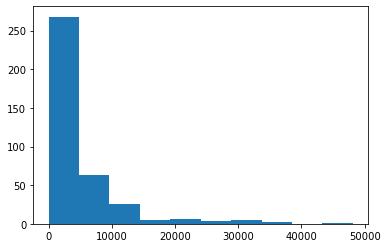

In [67]:
# look at histogram of avg_daily_entries_exits
plt.hist(station_daily_avg_counts.avg_daily_entries_exits)

- Again, we can see that the distribution average daily entries/exits per station is very similar to that of the average daily entries and average daily exits per station.

# Visualize the top 5,  middle 5, and bottom 5 stations based on average daily entries/exits

In [68]:
# get index of middle row in df
mid_rw = round(len(station_daily_avg_counts)/2)

print(station_daily_avg_counts.iloc[mid_rw]) # index is 190

station                    LORIMER ST
daily_entries                    3166
daily_exits                      2773
count_dates                        97
avg_daily_entries_exits        2969.5
Name: 190, dtype: object


In [69]:
# get the middle 5 rows 
mid_daily_avg_counts = station_daily_avg_counts.iloc[188:193]
mid_daily_avg_counts

,station,daily_entries,daily_exits,count_dates,avg_daily_entries_exits
188,HARRISON,2779.0,3079.0,97,2929.0
189,PARSONS BLVD,2734.0,3147.0,97,2940.5
190,LORIMER ST,3166.0,2773.0,97,2969.5
191,RECTOR ST,3235.0,2741.0,97,2988.0
192,ROOSEVELT ISLND,2819.0,3325.0,97,3072.0


In [70]:
# get the bottom 5 rows
low_daily_avg_counts = station_daily_avg_counts.iloc[0:5]
low_daily_avg_counts

,station,daily_entries,daily_exits,count_dates,avg_daily_entries_exits
0,ORCHARD BEACH,7.0,4.0,54,5.5
1,BROAD CHANNEL,112.0,71.0,97,91.5
2,TOMPKINSVILLE,280.0,0.0,97,140.0
3,BEACH 105 ST,115.0,195.0,97,155.0
4,BEACH 98 ST,170.0,265.0,97,217.5


In [71]:
# get the top 5 rows
high_daily_avg_counts = station_daily_avg_counts.iloc[374:]
high_daily_avg_counts

,station,daily_entries,daily_exits,count_dates,avg_daily_entries_exits
374,14 ST-UNION SQ,26325.0,36827.0,97,31576.0
375,86 ST,28817.0,38416.0,97,33616.5
376,GRD CNTRL-42 ST,29189.0,40888.0,97,35038.5
377,34 ST-HERALD SQ,32487.0,42417.0,97,37452.0
378,34 ST-PENN STA,41056.0,55227.0,97,48141.5


Text(0.5, 1.0, 'MTA stations with the Most Avg. Daily Entries/Exits \n from late April 2021 - July 2021')

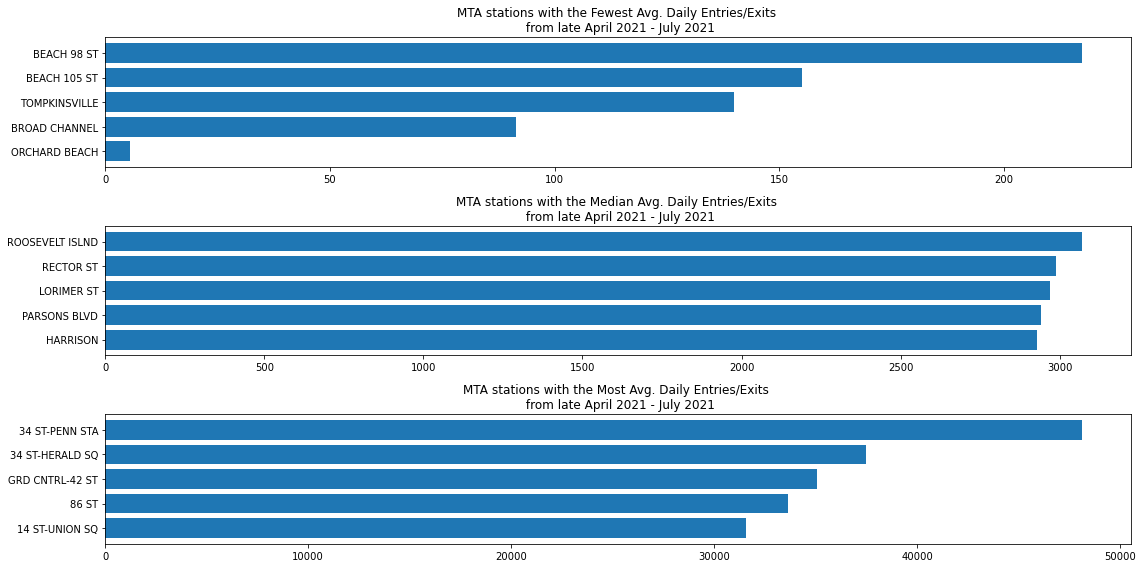

In [72]:
stations_1 = list(low_daily_avg_counts.station)
stations_1_values = list(low_daily_avg_counts.avg_daily_entries_exits)

stations_2 = list(mid_daily_avg_counts.station)
stations_2_values = list(mid_daily_avg_counts.avg_daily_entries_exits)

stations_3 = list(high_daily_avg_counts.station)
stations_3_values = list(high_daily_avg_counts.avg_daily_entries_exits)

plt.figure(figsize=(16, 8))

plt.subplot(3, 1, 1)
plt.barh(stations_1, stations_1_values)
plt.title('MTA stations with the Fewest Avg. Daily Entries/Exits \n from late April 2021 - July 2021')

plt.subplot(3, 1, 2)
plt.barh(stations_2, stations_2_values)
plt.title('MTA stations with the Median Avg. Daily Entries/Exits \n from late April 2021 - July 2021')

plt.subplot(3, 1, 3)
plt.barh(stations_3, stations_3_values)
plt.tight_layout()
plt.title('MTA stations with the Most Avg. Daily Entries/Exits \n from late April 2021 - July 2021')

- Ideally, outreach about composting would take place at stations with closest to the median number of average daily entries/exits, which is around 3000. 

# Clean mta stations location data
- The second criterion for selection MTA stations at which to do outreach to promote composting is proximity to food scrap drop-off sites.
- Since location data was not in the turnstiles dataset, I needed to get it from another dataset.
- Before merging the average daily entries/exits per station df with the stations location dataset, I must clean the stations location dataset.

In [73]:
mta_stations.shape

(496, 15)

In [74]:
mta_stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 496 entries, 0 to 495
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Station ID             496 non-null    int64  
 1   Complex ID             496 non-null    int64  
 2   GTFS Stop ID           496 non-null    object 
 3   Division               496 non-null    object 
 4   Line                   496 non-null    object 
 5   Stop Name              496 non-null    object 
 6   Borough                496 non-null    object 
 7   Daytime Routes         496 non-null    object 
 8   Structure              496 non-null    object 
 9   GTFS Latitude          496 non-null    float64
 10  GTFS Longitude         496 non-null    float64
 11  North Direction Label  478 non-null    object 
 12  South Direction Label  481 non-null    object 
 13  ADA                    496 non-null    int64  
 14  ADA Notes              9 non-null      object 
dtypes: flo

In [75]:
mta_stations.columns

Index(['Station ID', 'Complex ID', 'GTFS Stop ID', 'Division', 'Line',
       'Stop Name', 'Borough', 'Daytime Routes', 'Structure', 'GTFS Latitude',
       'GTFS Longitude', 'North Direction Label', 'South Direction Label',
       'ADA', 'ADA Notes'],
      dtype='object')

In [76]:
# update column names by making them all lower case and remove spaces
mta_stations.columns = [column.lower().replace(" ", "_") for column in mta_stations.columns]
mta_stations.columns

Index(['station_id', 'complex_id', 'gtfs_stop_id', 'division', 'line',
       'stop_name', 'borough', 'daytime_routes', 'structure', 'gtfs_latitude',
       'gtfs_longitude', 'north_direction_label', 'south_direction_label',
       'ada', 'ada_notes'],
      dtype='object')

In [77]:
mta_stations.head()

,station_id,complex_id,gtfs_stop_id,division,line,stop_name,borough,daytime_routes,structure,gtfs_latitude,gtfs_longitude,north_direction_label,south_direction_label,ada,ada_notes
0,119,119,L06,BMT,Canarsie,1 Av,M,L,Subway,40.730953,-73.981628,8 Av,Brooklyn,1,NaN
1,156,156,A18,IND,8th Av - Fulton St,103 St,M,B C,Subway,40.796092,-73.961454,Uptown & The Bronx,Downtown & Brooklyn,0,NaN
2,309,309,119,IRT,Broadway - 7Av,103 St,M,1,Subway,40.799446,-73.968379,Uptown & The Bronx,Downtown,0,NaN
3,395,395,624,IRT,Lexington Av,103 St,M,6,Subway,40.790600,-73.947478,Uptown & The Bronx,Downtown,0,NaN
4,450,450,706,IRT,Flushing,103 St-Corona Plaza,Q,7,Elevated,40.749865,-73.862700,Flushing,Manhattan,0,NaN


In [78]:
# count number of unique stations in stop_name column
len(mta_stations.stop_name.unique())

379

In [79]:
# create new column that combines latitude and longitude to find out how many are unique
mta_stations['lat_long'] = mta_stations['gtfs_latitude'].astype(str) + " " + mta_stations['gtfs_longitude'].astype(str)
len(mta_stations.lat_long.unique())

493

- The above two cells illustrate that there are multiple locations per station. This is because stations generally have more than one entrance/exit.
- For simplicity, I am going to use only one location per station, so I will only keep the first location listed per station.

In [80]:
# drop duplicate stations, keep first instance
mta_stations.drop_duplicates(subset=['stop_name'], keep='first', inplace=True)

In [81]:
mta_stations.shape

(379, 16)

In [82]:
# drop columns not needed for analysis
mta_stations = mta_stations.drop(['station_id', 'complex_id', 'gtfs_stop_id', 'division', 'line',
                                 'daytime_routes', 'structure', 'north_direction_label', 'south_direction_label',
                                 'ada', 'ada_notes'], axis=1, errors="ignore")
mta_stations.head()

,stop_name,borough,gtfs_latitude,gtfs_longitude,lat_long
0,1 Av,M,40.730953,-73.981628,40.730953 -73.981628
1,103 St,M,40.796092,-73.961454,40.796092 -73.961454
4,103 St-Corona Plaza,Q,40.749865,-73.862700,40.749865 -73.8627
5,104 St,Q,40.695178,-73.844330,40.695178000000006 -73.84433
7,110 St,M,40.795020,-73.944250,40.79502 -73.94425


# Merge dfs mta_stations with station_daily_avg_counts

In [83]:
print(mta_stations.shape)
print(station_daily_avg_counts.shape)

(379, 5)
(379, 5)


In [84]:
# look for columns in common
mta_stations.columns.intersection(station_daily_avg_counts)

Index([], dtype='object')

- Since there are no columns in common on which to merge, I must look at each df's column names to determine what they could be merged on.

In [85]:
print(mta_stations.columns)
print(station_daily_avg_counts.columns)

Index(['stop_name', 'borough', 'gtfs_latitude', 'gtfs_longitude', 'lat_long'], dtype='object')
Index(['station', 'daily_entries', 'daily_exits', 'count_dates',
       'avg_daily_entries_exits'],
      dtype='object')


- The above cell shows that the column containing station name is named differently in each df.
- Since those are the columns on which I want to merge, I will ensure that the data within them is formatted the same.

In [86]:
# look at values of stop_name in mta_stations
mta_stations.stop_name.value_counts().head()

Huguenot          1
169 St            1
52 St             1
Castle Hill Av    1
Bay 50 St         1
Name: stop_name, dtype: int64

In [87]:
# look at values of station in mta_stations
station_daily_avg_counts.station.value_counts().head()

LEXINGTON AV/63    1
MOSHOLU PKWY       1
RALPH AV           1
182-183 STS        1
LIVONIA AV         1
Name: station, dtype: int64

- The columns are are not formatted the same, so this must be done for the merge to work.

In [88]:
# to merge dfs on station/stop_name, make them both all lower case
mta_stations['stop_name'] = [name.lower() for name in mta_stations.stop_name]
station_daily_avg_counts['station'] = [name.lower() for name in station_daily_avg_counts.station]

In [168]:
stations_merged = station_daily_avg_counts.merge(mta_stations, how='left', left_on='station', right_on='stop_name')

## Check Merge

In [169]:
stations_merged.shape

(379, 10)

In [170]:
stations_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 379 entries, 0 to 378
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   station                  379 non-null    object 
 1   daily_entries            379 non-null    float64
 2   daily_exits              379 non-null    float64
 3   count_dates              379 non-null    int64  
 4   avg_daily_entries_exits  379 non-null    float64
 5   stop_name                256 non-null    object 
 6   borough                  256 non-null    object 
 7   gtfs_latitude            256 non-null    float64
 8   gtfs_longitude           256 non-null    float64
 9   lat_long                 256 non-null    object 
dtypes: float64(5), int64(1), object(4)
memory usage: 32.6+ KB


In [92]:
# look at some columns where lat and long columns are null
stations_merged[stations_merged.lat_long.isna()]

,station,daily_entries,daily_exits,count_dates,avg_daily_entries_exits,stop_name,borough,gtfs_latitude,gtfs_longitude,lat_long
0,orchard beach,7.0,4.0,54,5.5,NaN,NaN,NaN,NaN,NaN
7,aqueduct racetr,633.0,132.0,97,382.5,NaN,NaN,NaN,NaN,NaN
9,rockaway park b,328.0,488.0,97,408.0,NaN,NaN,NaN,NaN,NaN
15,e 143/st mary's,462.0,682.0,97,572.0,NaN,NaN,NaN,NaN,NaN
16,aqueduct n.cond,320.0,849.0,97,584.5,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
364,jksn ht-roosvlt,20648.0,20065.0,97,20356.5,NaN,NaN,NaN,NaN,NaN
368,flushing-main,22691.0,25694.0,97,24192.5,NaN,NaN,NaN,NaN,NaN
373,42 st-port auth,27807.0,33747.0,97,30777.0,NaN,NaN,NaN,NaN,NaN
376,grd cntrl-42 st,29189.0,40888.0,97,35038.5,NaN,NaN,NaN,NaN,NaN


- The above shows that not every station appeared in both merge dfs. 
- To figure out why that might be, let's look at whether the 5 stations with median average daily entries/exits appear in both.

In [171]:
mid_stations = mid_daily_avg_counts.station.str.lower()
print(mid_stations)
stations_merged[stations_merged.stop_name.isin(mid_stations) == True]

188           harrison
189       parsons blvd
190         lorimer st
191          rector st
192    roosevelt islnd
Name: station, dtype: object


,station,daily_entries,daily_exits,count_dates,avg_daily_entries_exits,stop_name,borough,gtfs_latitude,gtfs_longitude,lat_long
189,parsons blvd,2734.0,3147.0,97,2940.5,parsons blvd,Q,40.707564,-73.803326,40.707564 -73.803326
190,lorimer st,3166.0,2773.0,97,2969.5,lorimer st,Bk,40.703869,-73.947408,40.703869 -73.947408
191,rector st,3235.0,2741.0,97,2988.0,rector st,M,40.707220,-74.013342,40.70722 -74.01334200000001
192,roosevelt islnd,2819.0,3325.0,97,3072.0,roosevelt islnd,M,40.759145,-73.953260,40.759145000000004 -73.95326


- The above shows that only 3 appear in the merged df, which could mean one of two things:
   - 1. the other two stations in the df with average daily entries/exits per station didn't appear in the stations location df
   - 2. the stations appeared in both but were spelled differently
- I'll investigate theory #2 using the Roosevelt Island station.

In [172]:
# look for stop_names in mta_stations that start with 'r' to see if one is roosevelt islnd spelled different
mta_stations[mta_stations.stop_name.str.startswith('r') == True]

,stop_name,borough,gtfs_latitude,gtfs_longitude,lat_long
435,ralph av,Bk,40.678822,-73.920786,40.678822 -73.92078599999999
436,rector st,M,40.707220,-74.013342,40.70722 -74.01334200000001
438,richmond valley,SI,40.519631,-74.229141,40.519631 -74.229141
439,rockaway av,Bk,40.678340,-73.911946,40.678340000000006 -73.911946
441,rockaway blvd,Q,40.680429,-73.843853,40.680429 -73.843853
442,rockaway park-beach 116 st,Q,40.580903,-73.835592,40.580903 -73.835592
443,roosevelt islnd,M,40.759145,-73.953260,40.759145000000004 -73.95326


- The above shows that the Roosevelt Island station is spelled 'roosevelt island' (not 'roosevelt islnd') in the mta stations location df. Because of this discrepancy, the rows didn't merge on each other.
- I'll rename the station in the mta stations locations df so it matches for a re-merge.

In [173]:
# rename stop_name 'roosevelt island' in mta_stations to match with station_daily_avg_counts
mta_stations.loc[443, 'stop_name'] = 'roosevelt islnd'

- I'll now look for the other station with median average daily entries/exits - Harrison - in the mta stations locations df.

In [174]:
# look for stop_names in mta_stations that start with 'h' to see if one is harrison spelled different
mta_stations[mta_stations.stop_name.str.startswith('h') == True] # no matches

,stop_name,borough,gtfs_latitude,gtfs_longitude,lat_long
336,halsey st,Bk,40.686370,-73.916559,40.686370000000004 -73.91655899999999
338,harlem-148 st,M,40.823880,-73.936470,40.823879999999996 -73.93647
339,hewes st,Bk,40.706870,-73.953431,40.70687 -73.95343100000001
340,high st,Bk,40.699337,-73.990531,40.699337 -73.990531
341,houston st,M,40.728251,-74.005367,40.728251 -74.005367
342,howard beach-jfk airport,Q,40.660476,-73.830301,40.660476 -73.830301
343,hoyt st,Bk,40.690545,-73.985065,40.690545 -73.985065
344,hoyt-schermerhorn sts,Bk,40.688484,-73.985001,40.688484 -73.985001
345,huguenot,SI,40.533674,-74.191794,40.533674 -74.19179399999999
346,hunters point av,Q,40.742216,-73.948916,40.742216 -73.948916


- Harrison does not appear in the mta stations locations df, even under a different spelling. 
- I searched for this station online and discovered it's part of the Metro-North commuter rail line, so it's not a traditional subway line stop; I suspect that's why it's absent from the MTA stations locations df.
- Given this finding, I'll look for the station just before it in the df station_daily_avg_counts that's sorted by the number of average daily entries/exits.

In [175]:
station_daily_avg_counts.iloc[187:193]

,station,daily_entries,daily_exits,count_dates,avg_daily_entries_exits
187,ozone pk leffrt,2898.0,2955.0,97,2926.5
188,harrison,2779.0,3079.0,97,2929.0
189,parsons blvd,2734.0,3147.0,97,2940.5
190,lorimer st,3166.0,2773.0,97,2969.5
191,rector st,3235.0,2741.0,97,2988.0
192,roosevelt islnd,2819.0,3325.0,97,3072.0


In [176]:
# check if 'ozone pk leffrt' is in stations_merged
stations_merged[stations_merged.station == 'ozone pk leffrt']

,station,daily_entries,daily_exits,count_dates,avg_daily_entries_exits,stop_name,borough,gtfs_latitude,gtfs_longitude,lat_long
187,ozone pk leffrt,2898.0,2955.0,97,2926.5,ozone pk leffrt,Q,40.685951,-73.825798,40.685951 -73.82579799999999


- Like the Roosevelt Island station, its location data does not appear in the merged df so I will look for stations that begin with 'o' in the mta stations locations df to see if it's spelled differently.

In [177]:
mta_stations[mta_stations.stop_name.str.startswith('o') == True]

,stop_name,borough,gtfs_latitude,gtfs_longitude,lat_long
412,oakwood heights,SI,40.565110,-74.126320,40.56511 -74.12631999999999
413,ocean pkwy,Bk,40.576312,-73.968501,40.576312 -73.968501
414,old town,SI,40.596612,-74.087368,40.596612 -74.08736800000001
415,ozone pk leffrt,Q,40.685951,-73.825798,40.685951 -73.82579799999999


- Indeed, it is!
- Again, I'll rename the station in the mta stations locations df so it matches for a re-merge.

In [178]:
# rename stop_name 'ozone park-lefferts blvd' in mta_stations to match with station_daily_avg_counts
mta_stations.loc[415, 'stop_name'] = 'ozone pk leffrt'

## Re-merge station_daily_avg_counts with mta_stations
- I could keep investigating the stations in the merged file who are missing locations data to figure out if it's because the station names were spelled differently in the dfs that were merged. However, since there are over 100, I am going to move on and only re-merge to obtain locations for the two stations I investigated.

In [179]:
# re-merge station_daily_avg_counts with mta_stations to get a match for the Roosevelt Island and 
  # Ozone Park-Lefferts Blvd stations
stations_merged = station_daily_avg_counts.merge(mta_stations, how='left', left_on='station', right_on='stop_name')

## Check re-merge

In [180]:
stations_merged.shape

(379, 10)

In [181]:
stations_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 379 entries, 0 to 378
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   station                  379 non-null    object 
 1   daily_entries            379 non-null    float64
 2   daily_exits              379 non-null    float64
 3   count_dates              379 non-null    int64  
 4   avg_daily_entries_exits  379 non-null    float64
 5   stop_name                256 non-null    object 
 6   borough                  256 non-null    object 
 7   gtfs_latitude            256 non-null    float64
 8   gtfs_longitude           256 non-null    float64
 9   lat_long                 256 non-null    object 
dtypes: float64(5), int64(1), object(4)
memory usage: 32.6+ KB


- We can see that the re-merge worked to yield two fewer stations missing locations data!

# Clean stations_merged

In [182]:
# drop rows with NaN
stations_merged = stations_merged.dropna().reset_index(drop=True)

In [183]:
# drop columns not needed for analysis
stations_merged.drop(columns=['daily_entries', 'daily_exits', 'count_dates',
                             'stop_name'], inplace=True)

In [184]:
stations_merged.shape

(256, 6)

In [185]:
stations_merged.head()

,station,avg_daily_entries_exits,borough,gtfs_latitude,gtfs_longitude,lat_long
0,broad channel,91.5,Q,40.608382,-73.815925,40.608382 -73.815925
1,tompkinsville,140.0,SI,40.636949,-74.074835,40.636949 -74.074835
2,beach 105 st,155.0,Q,40.583209,-73.827559,40.583209000000004 -73.827559
3,beach 98 st,217.5,Q,40.585307,-73.820558,40.585307 -73.82055799999999
4,beach 44 st,367.5,Q,40.592943,-73.776013,40.592943 -73.776013


In [186]:
stations_merged.tail()

,station,avg_daily_entries_exits,borough,gtfs_latitude,gtfs_longitude,lat_long
251,23 st,29578.5,M,40.741303,-73.989344,40.741303 -73.98934399999999
252,125 st,29866.5,M,40.811109,-73.952343,40.811109 -73.952343
253,14 st-union sq,31576.0,M,40.735736,-73.990568,40.735735999999996 -73.99056800000001
254,86 st,33616.5,Bk,40.622687,-74.028398,40.622687 -74.028398
255,34 st-herald sq,37452.0,M,40.749567,-73.987950,40.749567 -73.98795


In [187]:
stations_merged.borough.value_counts()

Bk    105
M      60
Bx     47
Q      43
SI      1
Name: borough, dtype: int64

In [188]:
# recode values of borough column
stations_merged['borough'] = stations_merged.borough.replace({'M':'Manhattan',
                                                             'Bk':'Brooklyn',
                                                             'Q':'Queens',
                                                             'Bx':'Bronx',
                                                             'SI':'Staten Island'})

In [189]:
stations_merged.head()

,station,avg_daily_entries_exits,borough,gtfs_latitude,gtfs_longitude,lat_long
0,broad channel,91.5,Queens,40.608382,-73.815925,40.608382 -73.815925
1,tompkinsville,140.0,Staten Island,40.636949,-74.074835,40.636949 -74.074835
2,beach 105 st,155.0,Queens,40.583209,-73.827559,40.583209000000004 -73.827559
3,beach 98 st,217.5,Queens,40.585307,-73.820558,40.585307 -73.82055799999999
4,beach 44 st,367.5,Queens,40.592943,-73.776013,40.592943 -73.776013


In [271]:
# look at SI station
stations_merged[stations_merged.borough == 'Staten Island']

,station,avg_daily_entries_exits,borough,gtfs_latitude,gtfs_longitude,lat_long
1,tompkinsville,140.0,Staten Island,40.636949,-74.074835,40.636949 -74.074835


(array([162.,  56.,  13.,  13.,   1.,   3.,   2.,   3.,   2.,   1.]),
 array([   91.5 ,  3827.55,  7563.6 , 11299.65, 15035.7 , 18771.75,
        22507.8 , 26243.85, 29979.9 , 33715.95, 37452.  ]),
 <a list of 10 Patch objects>)

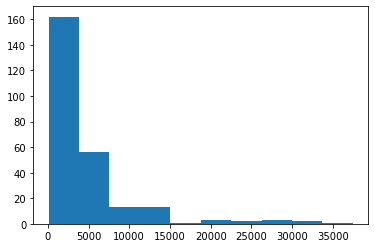

In [190]:
# look at histogram of avg_daily_entries_exits in stations_merged
plt.hist(stations_merged.avg_daily_entries_exits)

In [110]:
stations_merged.avg_daily_entries_exits.describe()

count      256.000000
mean      4649.511719
std       5865.731547
min         91.500000
25%       1458.250000
50%       2689.250000
75%       5025.250000
max      37452.000000
Name: avg_daily_entries_exits, dtype: float64

- Going back to my criteria for selecting stations at which to do outreach about composting, one of them is traffic flow. 
- The above cell shows that the median average daily entries/exits per station is 2689.5, which seems like a good sized pool of people to reach (too many people creates congestion and people might be less inclined to stop at a booth to chat or even notice their surroundings).
- Thus, I decided to create a df that only contains stations with between 2500 and 3000 average daily entries/exits.

In [191]:
stations_merged_rev = stations_merged[(stations_merged.avg_daily_entries_exits > 2500) & (stations_merged.avg_daily_entries_exits < 3000)]

In [192]:
stations_merged_rev.shape

(24, 6)

# Clean food scrap drop-off sites location data
- Next, I must prepare the food scrap drop-off sites location data in order to meet my second criteria for station selection: proximity to food scrap drop-off sites.

In [204]:
compost_drop_off.shape

(248, 19)

In [205]:
compost_drop_off.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248 entries, 0 to 247
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Borough                        247 non-null    object 
 1   CouncilDist                    248 non-null    int64  
 2   Food_Scrap_Drop_Off_Site_Name  248 non-null    object 
 3   Hours_from                     245 non-null    object 
 4   Hours_to                       245 non-null    object 
 5   Latitude                       248 non-null    float64
 6   Location                       248 non-null    object 
 7   Longitude                      248 non-null    float64
 8   NTAName                        248 non-null    object 
 9   Notes                          8 non-null      object 
 10  ObjectId                       0 non-null      float64
 11  Operation_Day                  248 non-null    object 
 12  Open_Months                    248 non-null    obj

In [206]:
compost_drop_off.head()

,Borough,CouncilDist,Food_Scrap_Drop_Off_Site_Name,Hours_from,Hours_to,Latitude,Location,Longitude,NTAName,Notes,ObjectId,Operation_Day,Open_Months,Serviced_by,Website,boroCD,ct2010,point,zip_code
0,Bronx,8,Brook Park,6pm,10am,40.809601,494 East 141 St.,-73.918701,Mott Haven-Port Morris,NaN,NaN,Saturday,Year Round,Brook Park,NaN,201,4000,POINT (-73.9187 40.809599),10454
1,Bronx,16,OPENING JULY 10: 170 Farmstand,5:30 PM,2:30 PM,40.839985,"Townsend Ave & 170 St, Bronx",-73.916817,West Concourse,NaN,NaN,Wednesdays,"Seasonal Market, July-November",GrowNYC,https://www.grownyc.org/compost/locations; htt...,204,223,POINT (-73.91682 40.839985),10452
2,Manhattan,3,Hudson Blvd Park,6:00 PM,10:00 AM,40.755554,5 Hudson Blvd East,-74.000351,Hudson Yards-Chelsea-Flatiron-Union Square,NaN,NaN,Thursdays,Year Round,Hudson Yards/ Hell's Kitchen Alliance,hyhalliance.org,104,99,POINT (-74.000348 40.755554),10001
3,Staten Island,49,Olivet Heavenly Harvest,1:00 PM,10:00 AM,40.630199,"97 Myrtle Avenue, Staten Island, NY",-74.115967,New Brighton-Silver Lake,NaN,NaN,Saturdays,"Seasonal, March-November",Olivet Presbyterian Church,www.olivetcares.org,501,4006,POINT (-74.115963 40.630199),10310
4,Brooklyn,43,4th Avenue Presbyterian Church,12:00 PM,Dawn,40.635471,6753 4th Avenue,-74.022797,Bay Ridge,NaN,NaN,Saturdays,Year Round,4th Avenue Presbyterian Church,http://www.fourthavenuepresbyterian.org/,310,1004,POINT (-74.0228 40.635473),11220


In [207]:
# make all column names lowercase
compost_drop_off.columns = [column.lower() for column in compost_drop_off.columns]

In [208]:
compost_drop_off.columns

Index(['borough', 'councildist', 'food_scrap_drop_off_site_name', 'hours_from',
       'hours_to', 'latitude', 'location', 'longitude', 'ntaname', 'notes',
       'objectid', 'operation_day', 'open_months', 'serviced_by', 'website',
       'borocd', 'ct2010', 'point', 'zip_code'],
      dtype='object')

In [209]:
# create new column that combines latitude and longitude to find out how many are unique
compost_drop_off['lat_long'] = compost_drop_off['latitude'].astype(str) + " " + compost_drop_off['longitude'].astype(str)

In [210]:
# get the number of unique lat, long in compost_drop_off
len(pd.unique(compost_drop_off['lat_long'])) #165 lat, long

165

In [211]:
# get the number of unique sites in compost_drop_off
len(pd.unique(compost_drop_off['food_scrap_drop_off_site_name']))

166

- There appears to be two food scrap drop-off sites with the same location.

In [212]:
# drop duplicate compost sites
compost_drop_off.drop_duplicates(subset=['food_scrap_drop_off_site_name'], keep='first', inplace=True)

In [213]:
# create new df with only columns needed in compost_drop_off
compost_drop_off = compost_drop_off.drop(['councildist', 'hours_from', 'hours_to', 'location', 'ntaname', 'notes',
                                'objectid', 'operation_day', 'open_months', 'serviced_by', 'website',
                                'borocd', 'ct2010', 'point', 'zip_code'], axis=1, errors="ignore")

In [214]:
compost_drop_off.head()

,borough,food_scrap_drop_off_site_name,latitude,longitude,lat_long
0,Bronx,Brook Park,40.809601,-73.918701,40.80960083 -73.91870117
1,Bronx,OPENING JULY 10: 170 Farmstand,40.839985,-73.916817,40.83998489 -73.91681671
2,Manhattan,Hudson Blvd Park,40.755554,-74.000351,40.7555542 -74.00035095
3,Staten Island,Olivet Heavenly Harvest,40.630199,-74.115967,40.63019943 -74.1159668
4,Brooklyn,4th Avenue Presbyterian Church,40.635471,-74.022797,40.63547134 -74.02279663


In [215]:
compost_drop_off.shape

(166, 5)

In [268]:
# look to see how many food scrap drop-off sites are located in each borough
compost_drop_off.borough.value_counts()

Manhattan        78
Brooklyn         28
Queens           28
Bronx            27
Staten Island     4
Name: borough, dtype: int64

# Create map of food scrap drop-off sites and stations
- Before calculating the actual distance between food scrap drop off sites and the potential stations at which to conduct outreach to promote composting, I decided to create a map showing food scrap drop off sites and the potential 24 stations.
- I used this article for help writing the code for the map: https://medium.com/@ianforrest11/graphing-latitudes-and-longitudes-on-a-map-bf64d5fca391

In [216]:
# import street map
os.chdir ('/Users/chloebergsma-safar/Desktop/Bootcamp_Data/Borough Boundaries')
street_map = gpd.read_file('geo_export_3b396110-9a73-4fd7-935d-741e423ac1be.shp')

In [217]:
# create geopandas df of food scrap drop off sites

# zip x and y coordinates into single feature
geo_compost = [Point(xy) for xy in zip(compost_drop_off['longitude'], compost_drop_off['latitude'])]

# create GeoPandas dataframe
geo_compost_df = gpd.GeoDataFrame(compost_drop_off,
 crs="EPSG:4326",
 geometry = geo_compost)

In [218]:
geo_compost_df.head()

,borough,food_scrap_drop_off_site_name,latitude,longitude,lat_long,geometry
0,Bronx,Brook Park,40.809601,-73.918701,40.80960083 -73.91870117,POINT (-73.91870 40.80960)
1,Bronx,OPENING JULY 10: 170 Farmstand,40.839985,-73.916817,40.83998489 -73.91681671,POINT (-73.91682 40.83998)
2,Manhattan,Hudson Blvd Park,40.755554,-74.000351,40.7555542 -74.00035095,POINT (-74.00035 40.75555)
3,Staten Island,Olivet Heavenly Harvest,40.630199,-74.115967,40.63019943 -74.1159668,POINT (-74.11597 40.63020)
4,Brooklyn,4th Avenue Presbyterian Church,40.635471,-74.022797,40.63547134 -74.02279663,POINT (-74.02280 40.63547)


In [219]:
# create geopandas df of stations 

# zip x and y coordinates into single feature
geo_stations_rev = [Point(xy) for xy in zip(stations_merged_rev['gtfs_longitude'], stations_merged_rev['gtfs_latitude'])]

# create GeoPandas dataframe
geo_stations_rev_df = gpd.GeoDataFrame(stations_merged_rev,
 crs="EPSG:4326",
 geometry = geo_stations_rev)

In [220]:
# create a dictionary to assign each station's borough a particular color
boroughPalette = {'Manhattan': 'red',
               'Bronx': 'purple',
               'Brooklyn': 'blue',
               'Queens': 'green'}
boroughPalette

{'Manhattan': 'red', 'Bronx': 'purple', 'Brooklyn': 'blue', 'Queens': 'green'}

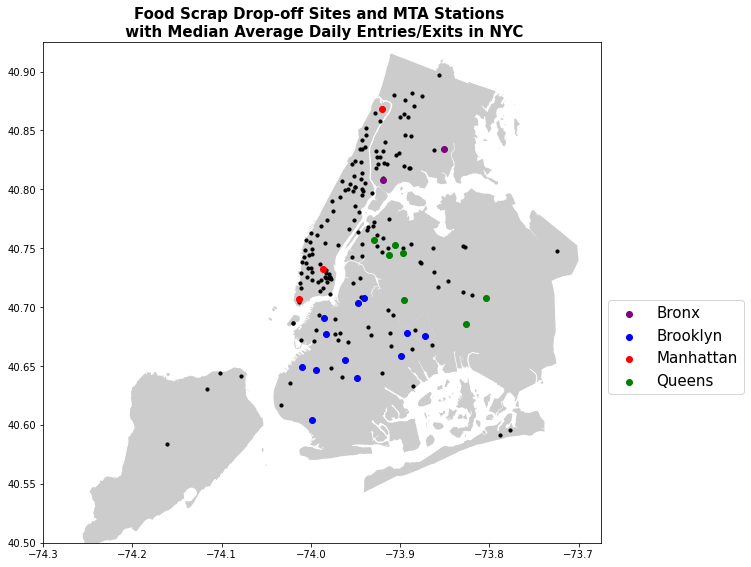

In [221]:
# create figure and axes, assign to subplot
fig, ax = plt.subplots(figsize=(10,10))

# add .shp mapfile to axes
street_map.plot(ax=ax, alpha=0.4,color='grey')

# add geodataframes to axes

# 1. compost geo df
geo_compost_df.plot(ax=ax,markersize=10, color='black')

# 2. stations df
for ctype, data in geo_stations_rev_df.groupby('borough'):
    
    # Define the color for each group using the dictionary
    color = boroughPalette[ctype]
    
    # Plot each group using the color defined above
    data.plot(color=color,
              ax=ax,
              label=ctype)

ax.legend(bbox_to_anchor=(1.0, .5), prop={'size': 15})

# add title to graph
plt.title('Food Scrap Drop-off Sites and MTA Stations \n with Median Average Daily Entries/Exits in NYC', fontsize=15, fontweight='bold')

# set latitiude and longitude boundaries for map display
plt.xlim(-74.3,-73.675)
plt.ylim(40.5,40.925)

# show map
plt.show()

- This map shows food scrap drop-off sites in black and the stations are color-coded according to their borough.
- It shows that food scrap drop-off sites are more densely located in Manhattan and the Bronx versus the other three boroughs.
- Also, it shows that there are several potential stations (based on criterion #1 - traffic flow) at which to do outreach that appear to be quite distant from food scrap drop-off stations.
- Therefore, the next step is to find the nearest food scrap drop-off sites to each of the above 24 potential stations.

## Find the closest food scrap drop-off sites to each potential outreach station
- I used this article for help writing the below code: https://medium.com/analytics-vidhya/finding-nearest-pair-of-latitude-and-longitude-match-using-python-ce50d62af546.

In [222]:
# create function that calculates haversine distance between two points
def dist(lat1, long1, lat2, long2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lat1, long1, lat2, long2 = map(radians, [lat1, long1, lat2, long2])
    # haversine formula 
    dlon = long2 - long1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # radius of earth in miles is 3,958.8 mi
    mi = 3958.8 * c
    return mi

- The above function will calculate the distance between each station and every food scrap drop-off site.

In [223]:
# rename latitude and longitude columns in dfs so they're shorter and the same
compost_drop_off = compost_drop_off.rename(columns={'latitude':'lat',
                                                   'longitude':'long'})
stations_merged_rev = stations_merged_rev.rename(columns={'gtfs_latitude':'lat',
                                                   'gtfs_longitude':'long'})

In [224]:
def find_nearest(lat, long):
    distances = compost_drop_off.apply(
        lambda row: dist(lat, long, row['lat'], row['long']), 
        axis=1)
    return compost_drop_off.loc[distances.idxmin(), 'food_scrap_drop_off_site_name']

- The above function will calculate the distance between each station and the nearest food scrap drop-off site using the first function that calculates the distance between two points. In this case, idxmin() returns the index of the minimum value in the food_scrap_drop_off_site_name column.
- Using the above function, we can apply it to the stations df.

In [225]:
stations_merged_rev['food_scrap_drop_off_site_name'] = stations_merged_rev.apply(
    lambda row: find_nearest(row['lat'], row['long']), 
    axis=1)

In [226]:
stations_merged_rev.head()

,station,avg_daily_entries_exits,borough,lat,long,lat_long,geometry,food_scrap_drop_off_site_name
118,9 av,2525.0,Brooklyn,40.646292,-73.994324,40.646291999999995 -73.994324,POINT (-73.99432 40.64629),East 4th Street Community Garden
119,parkside av,2570.0,Brooklyn,40.655292,-73.961495,40.655291999999996 -73.961495,POINT (-73.96149 40.65529),Parkside
120,van siclen av,2586.0,Brooklyn,40.678024,-73.891688,40.678024 -73.891688,POINT (-73.89169 40.67802),OPEN FOR SEASON: Essex Community Garden
121,fresh pond rd,2592.5,Queens,40.706186,-73.895877,40.706185999999995 -73.895877,POINT (-73.89588 40.70619),Bushwick Grows! Community Garden
122,northern blvd,2614.0,Queens,40.752885,-73.906006,40.752885 -73.906006,POINT (-73.90601 40.75288),Sunny Compost


## Calculate the distance between stations and the nearest food scrap drop-off sites.
- Now that I know which food scrap drop-off site is nearest each of the potential 24 stations at which to do outreach, I want to calculate the actual distance.

In [227]:
# Merge the stations and compost dfs
stations_final = pd.merge(stations_merged_rev,compost_drop_off[['food_scrap_drop_off_site_name','lat','long']],on='food_scrap_drop_off_site_name', how='left')

# Rename the new columns so it's clear which df columns with the same name came from 
  # ('s_' for stations df and 'c_' for compost data)
stations_final = stations_final.rename(columns = {'lat_x':'s_lat','long_x':'s_long','lat_y':'c_lat','long_y':'c_long'})

stations_final.head()

,station,avg_daily_entries_exits,borough,s_lat,s_long,lat_long,geometry,food_scrap_drop_off_site_name,c_lat,c_long
0,9 av,2525.0,Brooklyn,40.646292,-73.994324,40.646291999999995 -73.994324,POINT (-73.99432 40.64629),East 4th Street Community Garden,40.648212,-73.977097
1,parkside av,2570.0,Brooklyn,40.655292,-73.961495,40.655291999999996 -73.961495,POINT (-73.96149 40.65529),Parkside,40.654881,-73.961884
2,van siclen av,2586.0,Brooklyn,40.678024,-73.891688,40.678024 -73.891688,POINT (-73.89169 40.67802),OPEN FOR SEASON: Essex Community Garden,40.680264,-73.882980
3,fresh pond rd,2592.5,Queens,40.706186,-73.895877,40.706185999999995 -73.895877,POINT (-73.89588 40.70619),Bushwick Grows! Community Garden,40.697605,-73.913704
4,northern blvd,2614.0,Queens,40.752885,-73.906006,40.752885 -73.906006,POINT (-73.90601 40.75288),Sunny Compost,40.750046,-73.913757


In [228]:
# create a new column containing the distance between each station and the nearest food scrap drop-off site
  # by passing lat long info to the distance defined function above
stations_final['distance'] = [dist(stations_final.s_long[i],stations_final.s_lat[i],stations_final.c_long[i],stations_final.c_lat[i]) for i in range(len(stations_final))]
stations_final['distance'] = stations_final['distance'].round(decimals=3)

stations_final.head()

,station,avg_daily_entries_exits,borough,s_lat,s_long,lat_long,geometry,food_scrap_drop_off_site_name,c_lat,c_long,distance
0,9 av,2525.0,Brooklyn,40.646292,-73.994324,40.646291999999995 -73.994324,POINT (-73.99432 40.64629),East 4th Street Community Garden,40.648212,-73.977097,1.191
1,parkside av,2570.0,Brooklyn,40.655292,-73.961495,40.655291999999996 -73.961495,POINT (-73.96149 40.65529),Parkside,40.654881,-73.961884,0.028
2,van siclen av,2586.0,Brooklyn,40.678024,-73.891688,40.678024 -73.891688,POINT (-73.89169 40.67802),OPEN FOR SEASON: Essex Community Garden,40.680264,-73.882980,0.603
3,fresh pond rd,2592.5,Queens,40.706186,-73.895877,40.706185999999995 -73.895877,POINT (-73.89588 40.70619),Bushwick Grows! Community Garden,40.697605,-73.913704,1.243
4,northern blvd,2614.0,Queens,40.752885,-73.906006,40.752885 -73.906006,POINT (-73.90601 40.75288),Sunny Compost,40.750046,-73.913757,0.538


# Select a station, from each borough, with the shortest distance to the nearest food scrap drop-off site. 

In [229]:
# sort the df by distance
stations_final.sort_values(['distance'],inplace=True)

In [230]:
stations_final

,station,avg_daily_entries_exits,borough,s_lat,s_long,lat_long,geometry,food_scrap_drop_off_site_name,c_lat,c_long,distance
15,brook av,2852.5,Bronx,40.807566,-73.919240,40.807565999999994 -73.91924,POINT (-73.91924 40.80757),Brook Ave,40.807560,-73.919228,0.001
1,parkside av,2570.0,Brooklyn,40.655292,-73.961495,40.655291999999996 -73.961495,POINT (-73.96149 40.65529),Parkside,40.654881,-73.961884,0.028
19,inwood-207 st,2923.5,Manhattan,40.868072,-73.919899,40.868072 -73.919899,POINT (-73.91990 40.86807),Inwood Greenmarket,40.868999,-73.920319,0.034
23,rector st,2988.0,Manhattan,40.707220,-74.013342,40.70722 -74.01334200000001,POINT (-74.01334 40.70722),Bowling Green Greenmarket,40.704720,-74.013527,0.049
13,69 st,2789.5,Queens,40.746325,-73.896403,40.746325 -73.896403,POINT (-73.89640 40.74632),JH Scraps,40.749863,-73.896301,0.068
12,52 st,2748.0,Queens,40.744149,-73.912549,40.744149 -73.912549,POINT (-73.91255 40.74415),Sunny Compost,40.750046,-73.913757,0.140
5,3 av,2624.0,Manhattan,40.732849,-73.986122,40.732849 -73.986122,POINT (-73.98612 40.73285),14th Street Y,40.731213,-73.983360,0.193
22,lorimer st,2969.5,Brooklyn,40.703869,-73.947408,40.703869 -73.947408,POINT (-73.94741 40.70387),Scholes Street Children's Garden,40.708477,-73.944305,0.232
7,36 av,2653.5,Queens,40.756804,-73.929575,40.756803999999995 -73.929575,POINT (-73.92957 40.75680),Commuter Composting at Broadway N/W,40.761566,-73.925507,0.295
10,montrose av,2696.0,Brooklyn,40.707739,-73.939850,40.707739000000004 -73.93985,POINT (-73.93985 40.70774),Scholes Street Children's Garden,40.708477,-73.944305,0.308


In [231]:
# keep only the first row from each borough, which, given that the df is sorted in ascending order
  # by the distance column, will yield the station and food scrap drop-off site with the shortest distance between 
  # them in that borough
stations_final.drop_duplicates(subset=['borough'], keep='first', inplace=True)

In [232]:
stations_final

,station,avg_daily_entries_exits,borough,s_lat,s_long,lat_long,geometry,food_scrap_drop_off_site_name,c_lat,c_long,distance
15,brook av,2852.5,Bronx,40.807566,-73.919240,40.807565999999994 -73.91924,POINT (-73.91924 40.80757),Brook Ave,40.807560,-73.919228,0.001
1,parkside av,2570.0,Brooklyn,40.655292,-73.961495,40.655291999999996 -73.961495,POINT (-73.96149 40.65529),Parkside,40.654881,-73.961884,0.028
19,inwood-207 st,2923.5,Manhattan,40.868072,-73.919899,40.868072 -73.919899,POINT (-73.91990 40.86807),Inwood Greenmarket,40.868999,-73.920319,0.034
13,69 st,2789.5,Queens,40.746325,-73.896403,40.746325 -73.896403,POINT (-73.89640 40.74632),JH Scraps,40.749863,-73.896301,0.068


In [237]:
stations_final.station = [name.title() for name in stations_final.station]

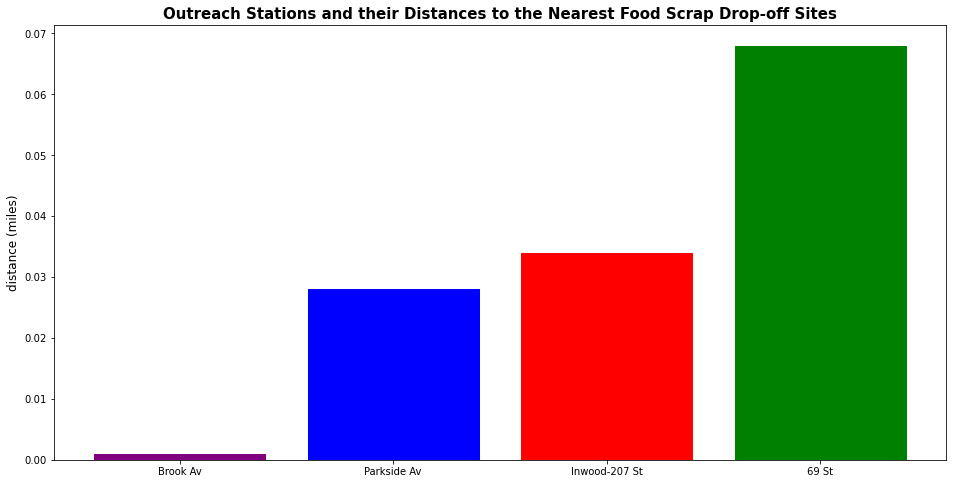

In [267]:
plt.figure(figsize=(16, 8))
ax = plt.bar(stations_final['station'], stations_final['distance'])
plt.title('Outreach Stations and their Distances to the Nearest Food Scrap Drop-off Sites',
          fontsize=15, fontweight='bold')
plt.ylabel('distance (miles)', fontsize=12)
for bar in ax:
    if bar.get_height() > .06:
        bar.set_color('green') 
    elif bar.get_height() > 0.03:
        bar.set_color('red')
    elif bar.get_height() > 0.02:
        bar.set_color('blue')
    else:
        bar.set_color('purple')

- The above code shows that there's no station in station island that met the first criterion about average number of daily entries/exits per station being between 2500-3000, so we are left with 4 stations, one in each of the other four boroughs, at which to do outreach about composting.

# Create a map that shows these four outreach stations and their nearest food scrap drop-off site

In [233]:
# create geopandas df of stations

# zip x and y coordinates into single feature
geo_station_2 = [Point(xy) for xy in zip(stations_final['s_long'], stations_final['s_lat'])]

# create GeoPandas dataframe
geo_station_2_df = gpd.GeoDataFrame(stations_final,
 crs="EPSG:4326",
 geometry = geo_station_2)

In [234]:
# create geopandas df of food scrap drop off sites

# zip x and y coordinates into single feature
geo_compost_2 = [Point(xy) for xy in zip(stations_final['c_long'], stations_final['c_lat'])]

# create GeoPandas dataframe
geo_compost_2_df = gpd.GeoDataFrame(stations_final,
 crs="EPSG:4326",
 geometry = geo_compost_2)

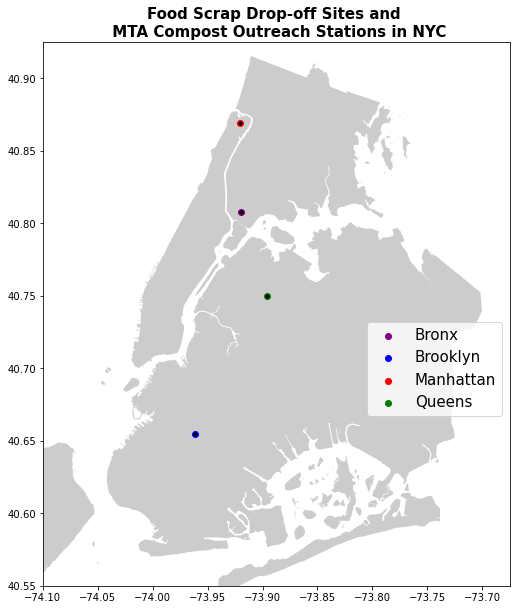

In [235]:
# create figure and axes, assign to subplot
fig, ax = plt.subplots(figsize=(10,10))

# add .shp mapfile to axes
street_map.plot(ax=ax, alpha=0.4,color='grey')

# add geodataframes to axes

# 1. stations df
for ctype, data in geo_station_2_df.groupby('borough'):
    
    # Define the color for each group using the dictionary
    color = boroughPalette[ctype]
    
    # Plot each group using the color defined above
    data.plot(color=color,
              ax=ax,
              label=ctype)

ax.legend(bbox_to_anchor=(1.0, .5), prop={'size': 15})

# 2. compost geo df
geo_compost_2_df.plot(ax=ax, markersize=10, color='black')

# add title to graph
plt.title('Food Scrap Drop-off Sites and \n MTA Compost Outreach Stations in NYC', fontsize=15, fontweight='bold')

# set latitiude and longitude boundaries for map display
plt.xlim(-74.1,-73.675)
plt.ylim(40.55,40.925)

# show map
plt.show()